**PREDICTING DIRECTION OF NEXT DAY STOCK PRICE MOVEMENT USING RANDOM FOREST**


In [2]:
%pip install scikit-learn


In [3]:
%pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=3ee3172b5ac51469e53e4a6e02411812b79c8c7092e9fa481bd5ac6c1201270b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
%pip install yfinance

In [5]:
import yfinance as yf
import pandas as pd
import os
import pandas_ta as ta
import numpy as np

In [6]:
def data(ticker):
  df = yf.Ticker(ticker)
  df = df.history(period="max")
  df.index = pd.to_datetime(df.index)
  del df["Dividends"]
  del df["Stock Splits"]
  df = df.loc["2014-01-01":].copy()
  df["Target"] = (df["Close"] > df["Open"]).astype(int).shift(-1)   ##Binary target...tomorrow increase or decrease direction as an output to be decided by todays statistics
  # frequency = df['Target'].value_counts()
  # print(frequency)
  df.dropna(inplace=True)
  return df

In [7]:
nifty=data("^NSEI")

In [8]:
nifty

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2014-01-02 00:00:00+05:30,6301.250000,6358.299805,6211.299805,6221.149902,158100,1.0
2014-01-03 00:00:00+05:30,6194.549805,6221.700195,6171.250000,6211.149902,139000,0.0
2014-01-06 00:00:00+05:30,6220.850098,6224.700195,6170.250000,6191.450195,118300,0.0
2014-01-07 00:00:00+05:30,6203.899902,6221.500000,6144.750000,6162.250000,138600,0.0
2014-01-08 00:00:00+05:30,6178.049805,6192.100098,6160.350098,6174.600098,146900,0.0
...,...,...,...,...,...,...
2024-07-18 00:00:00+05:30,24543.800781,24837.750000,24504.449219,24800.849609,350900,0.0
2024-07-19 00:00:00+05:30,24853.800781,24854.800781,24508.150391,24530.900391,343800,1.0
2024-07-22 00:00:00+05:30,24445.750000,24595.199219,24362.300781,24509.250000,324200,0.0


<Axes: xlabel='Date'>

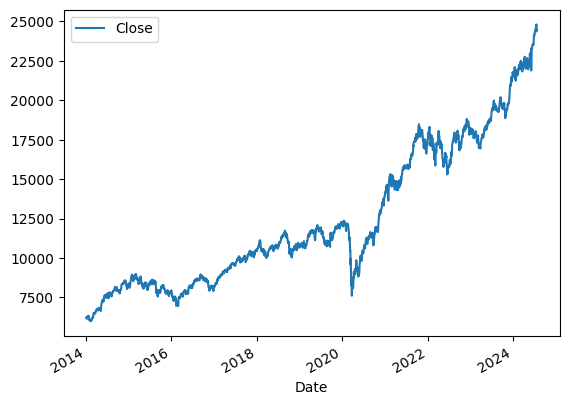

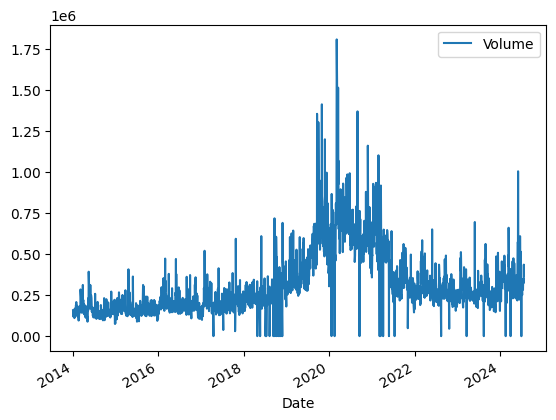

In [9]:
nifty.plot.line(y="Close", use_index=True)
nifty.plot.line(y="Volume", use_index=True)

**First we are going to make a simple model with less features using random forest classifier of sklearn module**(which will predict whether the stock price will go up(1) or down(0) tomorrow) :

In [10]:
nifty=data("^NSEI")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=50,n_jobs=-1)
train= nifty.iloc[-400:-30]                     #Using only recent data and smaller test set to prevent overfitting and underfitting both
test = nifty.iloc[-30:-1]
features = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[features], train["Target"])
print(model.feature_importances_)
print("Training score",model.score(train[features], train["Target"]))

[0.19153477 0.25079093 0.18434354 0.18467707 0.18865369]
Training score 0.9540540540540541


Following are the results of the predictions of the model whether stock price will increase or decrease tomorrow using only "Close", "Volume", "Open", "High", "Low" prices of today :


In [12]:
from sklearn.metrics import accuracy_score

prediction = model.predict(test[features])
prediction = pd.Series(prediction, index=test.index)
print("Accuracy Score",accuracy_score(test["Target"], prediction))

Accuracy Score 0.6206896551724138


**For the following model, various indicators will be used (using pandas_ta) :**

In [13]:
# Calculating technical indicators using pandas_ta
nifty=data("^NSEI")
nifty['SMA_10'] = ta.sma(nifty['Close'], length=10)
nifty['EMA_10'] = ta.ema(nifty['Close'], length=10)
nifty['RSI_14'] = ta.rsi(nifty['Close'], length=14)
macd = ta.macd(nifty['Close'])
nifty['MACD'] = macd['MACD_12_26_9']
nifty['MACD_signal'] = macd['MACDs_12_26_9']
nifty['MACD_hist'] = macd['MACDh_12_26_9']
nifty['ATR'] = ta.atr(nifty['High'], nifty['Low'], nifty['Close'], length=14)
nifty['OBV'] = ta.obv(nifty['Close'], nifty['Volume'])
bbands = ta.bbands(nifty['Close'], length=20)
nifty['Upper_BB'] = bbands['BBU_20_2.0']
nifty['Middle_BB'] = bbands['BBM_20_2.0']
nifty['Lower_BB'] = bbands['BBL_20_2.0']

# Lagged features (kind of last five rows to predict the next row)
for lag in range(1, 10):  # Example: 1 to 5 days lag
    # lag-=1
    nifty[f'Close_t-{lag}'] = nifty['Close'].shift(lag)
    nifty[f'Open_t-{lag}'] = nifty['Open'].shift(lag)
    nifty[f'High_t-{lag}'] = nifty['High'].shift(lag)
    nifty[f'Low_t-{lag}'] = nifty['Low'].shift(lag)
    nifty[f'Volume_t-{lag}'] = nifty['Volume'].shift(lag)

# NaN values will be obviously generated by shifting
nifty = nifty.dropna()

nifty

,Open,High,Low,Close,Volume,Target,SMA_10,EMA_10,RSI_14,MACD,...,Close_t-8,Open_t-8,High_t-8,Low_t-8,Volume_t-8,Close_t-9,Open_t-9,High_t-9,Low_t-9,Volume_t-9
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-19 00:00:00+05:30,6132.049805,6160.350098,6125.750000,6152.750000,95200,0.0,6065.135059,6086.767606,53.324903,-49.153151,...,6036.299805,6028.350098,6048.350098,5965.399902,185500.0,6022.399902,6004.250000,6028.049805,5962.049805,166600.0
2014-02-20 00:00:00+05:30,6127.149902,6129.100098,6086.450195,6091.450195,132100,1.0,6072.040088,6087.618986,46.788779,-45.287959,...,6063.200195,6077.649902,6079.950195,6030.899902,181900.0,6036.299805,6028.350098,6048.350098,5965.399902,185500.0
2014-02-21 00:00:00+05:30,6108.299805,6159.649902,6108.000000,6155.450195,112600,1.0,6083.955127,6099.951933,53.233846,-36.638160,...,6053.450195,6072.799805,6083.049805,6046.399902,133100.0,6063.200195,6077.649902,6079.950195,6030.899902,181900.0
2014-02-24 00:00:00+05:30,6140.950195,6191.850098,6130.799805,6186.100098,144900,0.0,6096.245117,6115.615236,55.983473,-26.998716,...,6062.700195,6072.450195,6081.850098,6053.250000,150500.0,6053.450195,6072.799805,6083.049805,6046.399902,133100.0
2014-02-25 00:00:00+05:30,6205.700195,6216.850098,6176.600098,6200.049805,146300,1.0,6110.905078,6130.966976,57.216407,-18.025971,...,6084.000000,6085.350098,6106.600098,6077.399902,138500.0,6062.700195,6072.450195,6081.850098,6053.250000,150500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 00:00:00+05:30,24615.900391,24661.250000,24587.650391,24613.000000,283200,1.0,24400.849805,24376.252186,74.377006,367.703640,...,24302.150391,24369.949219,24401.000000,24281.000000,251200.0,24286.500000,24291.750000,24309.150391,24207.099609,0.0
2024-07-18 00:00:00+05:30,24543.800781,24837.750000,24504.449219,24800.849609,350900,0.0,24452.284766,24453.451718,77.411690,378.618226,...,24323.849609,24213.349609,24363.000000,24168.849609,298400.0,24302.150391,24369.949219,24401.000000,24281.000000,251200.0
2024-07-19 00:00:00+05:30,24853.800781,24854.800781,24508.150391,24530.900391,343800,1.0,24475.159766,24467.533294,65.420695,361.320392,...,24320.550781,24329.449219,24344.599609,24240.550781,266300.0,24323.849609,24213.349609,24363.000000,24168.849609,298400.0


Lets firstly define all of these things features...later we will find which ones are more important(or all of them are :)


In [15]:
# Defining self-customized sets of features and target variable
featuresl = [
    'Close_t-1', 'Close_t-2', 'Close_t-3', 'Close_t-4', 'Close_t-5',
    'Open_t-1', 'High_t-1', 'Low_t-1', 'Volume_t-1',
    'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB',
]
featuresq =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB','Open','High','Low','Close','Volume']  ##without lagged features
featuresw =['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal','Middle_BB','Open','Close','Volume']  ##without lagged feature..just another

In [19]:
# Defining set of all lagged features
lagged_features = [f'Close_t-{i}' for i in range(1, 10)] + [f'Open_t-{i}' for i in range(1, 10)] + [f'Volume_t-{i}' for i in range(1, 10)]

# Combine all features
all_features = featuresq + lagged_features
X=nifty[all_features]
y = nifty['Target']  # Binary target: 0 for price decrease, 1 for price increase

In [29]:
#Lets split the data for training and testing, maintaining the temporal order
def split_data(X, y):
  train_size = int(len(X) * 0.99)
  start_size=int(len(X)*0.85)
  X_train, X_test = X[start_size:train_size], X[train_size:]
  y_train, y_test = y[start_size:train_size], y[train_size:]
  return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = split_data(X, y)

Lets now build the model, using same parameters(later will tune them too) :

In [37]:
# Train-test split while maintaining the temporal order
def train_model():

  model = RandomForestClassifier(n_estimators=500, min_samples_split=15, random_state=6,min_samples_leaf=1,n_jobs=-1)
  model.fit(X_train, y_train)
  #Training set results
  prediction = model.predict(X_train)
  prediction = pd.Series(prediction, index=X_train.index)
  df=pd.concat([y_train, prediction], axis=1)
  # display(df)
  print("Accuracy Score",accuracy_score(y_train, prediction))
  return model
print("Importance of each feature :", model.feature_importances_)
print("Relative importance of each feature with respect to the minimum", model.feature_importances_ / model.feature_importances_.min())
model=train_model()

Importance of each feature : [0.11489518 0.11749081 0.10753119 0.09195677 0.0955521  0.101752
 0.10175859 0.09072845 0.09539233 0.08294258]
Relative importance of each feature with respect to the minimum [1.38523765 1.41653191 1.2964535  1.10867997 1.15202711 1.22677642
 1.22685588 1.09387067 1.15010089 1.        ]
Accuracy Score 0.9748603351955307


In [38]:
#Testing set results
prediction = model.predict(X_test)
prediction = pd.Series(prediction, index=X_test.index)
df=pd.concat([y_test, prediction], axis=1)
# display(df)
print("Accuracy Score",accuracy_score(y_test, prediction))

Accuracy Score 0.4230769230769231


In [46]:
#Lets select the top 5 features according to feature_importance and train on that
# Getting the feature importances
importances = model.feature_importances_
imp_features = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
imp_features = imp_features.sort_values(by='Importance', ascending=False)

In [41]:

# Selecting the top n features
n = 25
top_features = imp_features.head(n)['Feature'].tolist()

In [42]:
#Lets now train the model on that
X=nifty[top_features]
y = nifty['Target']  # Binary target: 0 for price decrease, 1 for price increase

In [43]:
#Lets set the data
X_train, X_test, y_train, y_test = split_data(X, y)

In [44]:
#Now model training
model=train_model()

Accuracy Score 0.9916201117318436


In [45]:
#Testing set results
prediction = model.predict(X_test)
prediction = pd.Series(prediction, index=X_test.index)
df=pd.concat([y_test, prediction], axis=1)
# display(df)
print("Test Accuracy Score",accuracy_score(y_test, prediction))

Test Accuracy Score 0.6153846153846154


Clearly we are getting accuracy around 60 percent. Now lets split the data of 10 years into 8-10 parts and train and test the model on each part.

In [155]:
#Data
X=nifty[all_features]
y = nifty['Target']  # Binary target: 0 for price decrease, 1 for price increase

In [156]:
#Lets now divide the data into sequences each of length n, where first a days in the sequence will be used for training and n-a for testing
#Then model will be trained one by one on each sequence
n=400
a=350
X_train, X_test, y_train, y_test = [], [], [], []
for i in range(len(X)//n):
    start=i*n
    end=start+n
    if end>+len(X):
        break
    X_train.append(X.iloc[start:start+a])
    X_test.append(X.iloc[start+a:end])
    y_train.append(y.iloc[start:start+a])
    y_test.append(y.iloc[start+a:end])



In [157]:
len(X_train)  ##No of parts

6

In [160]:
model3=RandomForestClassifier(n_estimators=500, min_samples_split=19, random_state=6,min_samples_leaf=1, max_features=25,n_jobs=-1)
results=pd.DataFrame()

model3_train_scores=[]
model3_test_scores=[]
print("Accuracy scores")
for i in range(len(X_train)):
    model3.fit(X_train[i], y_train[i])
    model3_train_scores.append(model3.score(X_train[i], y_train[i]))
    model3_test_scores.append(model3.score(X_test[i], y_test[i]))
    prediction = model3.predict(X_test[i])
    prediction = pd.Series(prediction, index=X_test[i].index)
    results=pd.concat([y_test[i], prediction], axis=1)
    results.columns=['Actual','Predicted']
    accuracy = accuracy_score(y_test[i], prediction)
    print(f"Iteration {i}: Testing Accuracy = {accuracy:.4f}","Training Score:",model3.score(X_train[i], y_train[i]))



Accuracy scores
Iteration 0: Testing Accuracy = 0.5600 Training Score: 0.9857142857142858
Iteration 1: Testing Accuracy = 0.6400 Training Score: 0.9828571428571429
Iteration 2: Testing Accuracy = 0.5000 Training Score: 0.9857142857142858
Iteration 3: Testing Accuracy = 0.4800 Training Score: 0.9885714285714285
Iteration 4: Testing Accuracy = 0.6800 Training Score: 0.9771428571428571
Iteration 5: Testing Accuracy = 0.6200 Training Score: 0.9828571428571429


In [159]:
#Lets see the mean performance on the test sets
print("Mean training score:",np.mean(model3_train_scores))
print("Mean testing score:",np.mean(model3_test_scores))

Mean training score: 0.9838095238095238
Mean testing score: 0.5800000000000001


I have found above maximum accuracy at 19 min sample split and 500 estimators.


Now parameter tuning:


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define lagged features and technical indicators
lagged_features = [f'Close_t-{i}' for i in range(1, 10)] + [f'Open_t-{i}' for i in range(1, 10)] + [f'Volume_t-{i}' for i in range(1, 10)]
featuresq = ['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist',
    'ATR', 'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'Open', 'High', 'Low', 'Close', 'Volume']

# Combine all features
all_features = featuresq + lagged_features

# Feature normalization
scaler = StandardScaler()
nifty[all_features] = scaler.fit_transform(nifty[all_features])

# Prepare your features and target
X = nifty[all_features]
y = nifty['Target']  # replace with your actual target column

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Perform RFE
rfe = RFE(estimator=rf, n_features_to_select=12)  # Adjust 'n_features_to_select' as needed
rfe.fit(X, y)

# Get the selected features
selected_features = [feature for feature, selected in zip(all_features, rfe.support_) if selected]
print(f'Selected Features: {selected_features}')

# Use only the selected features
X_selected = nifty[selected_features]

In [ ]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
acc=[]
for train_index, test_index in tscv.split(X_selected):
    X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', min_samples_split=10, min_samples_leaf=2,  random_state=42,n_jobs=-1)
    # Get probabilities on training set
    model.fit(X_train,y_train)
#     y_proba_train = model.predict_proba(X_train)

#     # Set custom threshold
#     threshold = 0.7
#     y_pred_train = (y_proba_train[:, 1] > threshold).astype(int)

#     # Fit the model with adjusted predictions
#     model.fit(X_train, y_pred_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)

    # Set custom threshold
    threshold = 0.55
    y_pred = (y_proba[:, 1] > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    print(f'Test Accuracy: {accuracy}')
mean_Acc=np.mean(acc)
print(f'Mean accuracy: {mean_Acc}')

Test Accuracy: 0.56
Test Accuracy: 0.5294117647058824
Test Accuracy: 0.5129411764705882
Test Accuracy: 0.52
Test Accuracy: 0.5247058823529411
Mean accuracy: 0.5294117647058822


In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [6,10, 20],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_selected, y)
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nifty, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [ ]:
nifty

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(nifty, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
predictions